# Continuous Diffusion

In [2]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def load_image(image_path, size=None):
    """Load an image from a file path and optionally resize it."""
    img = Image.open(image_path).convert('RGB')
    '''if size:
        img = img.resize((size, size), Image.ANTIALIAS)'''
    return img

def image_to_tensor(image):
    """Convert a PIL image to a PyTorch tensor."""
    tensor = torch.from_numpy(np.array(image)).float()
    return tensor.permute(2, 0, 1) / 255  # Normalize to [0, 1]

def tensor_to_image(tensor):
    """Convert a PyTorch tensor to a PIL image."""
    image = tensor.permute(1, 2, 0).cpu().numpy()
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(image)

def add_noise(image_tensor, t, beta_start=0.0001, beta_end=0.1, timesteps=None):
    """Add noise to the image tensor based on the diffusion timestep t."""
    betas = torch.linspace(beta_start, beta_end, timesteps)
    
    alphas = 1 - betas
    alpha_t_bar = torch.prod(alphas[:t])
    sqrt_alpha_t_bar = torch.sqrt(alpha_t_bar)
    sqrt_one_minus_alpha_t_bar = torch.sqrt(1 - alpha_t_bar)
    return image_tensor * sqrt_alpha_t_bar + torch.randn_like(image_tensor) * sqrt_one_minus_alpha_t_bar

def save_image(image, path, name, t):
    """Save the image at a specific timestep."""
    if not os.path.exists(path):
        os.makedirs(path)
    filename = f'{path}/{name}_step_{t}.png'
    image.save(filename)
    print(f'Saved: {filename}')

def diffusion_process(image_path, timesteps=10, save_path=None, image_size=256):
    """Simulate the diffusion process over a series of timesteps."""
    image = load_image(image_path, size=image_size)
    image_tensor = image_to_tensor(image)

    for t in np.linspace(0, timesteps-1):
        if int(t) % 10 == 0:
            t = int(t)
            noised_image_tensor = add_noise(image_tensor, t, timesteps=timesteps)
            noised_image = tensor_to_image(noised_image_tensor)
            save_image(noised_image, save_path, 'noised_image', t)

# Example usage:
diffusion_process('/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/IMG_6144.png', timesteps=100, save_path='/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion')


Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_0.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_10.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_20.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_30.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_40.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_50.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diffusion/noised_image_step_60.png
Saved: /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/figures/continuous_diff

# Noising Schedules

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


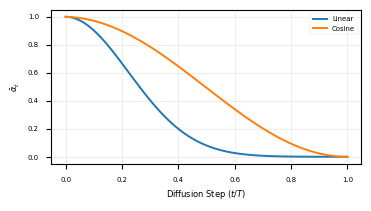

In [6]:
import torch
def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        def cosine_beta_schedule(timesteps, s=0.008):
            """
            Cosine schedule as described in https://arxiv.org/abs/2102.09672.

            Parameters:
            - timesteps: int, the number of timesteps for the schedule.
            - s: float, small constant to prevent numerical issues.

            Returns:
            - betas: torch.Tensor, beta values for each timestep.
            - alphas: torch.Tensor, alpha values for each timestep.
            - alpha_bars: torch.Tensor, cumulative product of alphas for each timestep.
            """
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps)
            alphas_cumprod = torch.cos((x / timesteps + s) / (1 + s) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

            betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
            alphas = 1 - betas
            alpha_bars = torch.cumprod(alphas, dim=0)

            return betas, alphas, alpha_bars
        betas, alphas, alpha_bars = cosine_beta_schedule(spec['num_timesteps'])
        return betas.to(device)
    
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])
    
import matplotlib.pyplot as plt
print(plt.style.available)
plt.style.use('seaborn-v0_8-paper')  # or 'ggplot', 'fivethirtyeight', etc.
plt.rcParams.update({
    'axes.labelsize': 6,
    'xtick.labelsize': 5,
    'ytick.labelsize': 5,
    'legend.fontsize': 5,
    'figure.figsize': (4, 2),
    'axes.grid': True,
    'grid.alpha': 0.2
})

spec = {'type': 'cosine', 'start': 0.01, 'stop': 0.99, 'num_timesteps': 1000}
betas = get_diffusion_betas(spec, 'cpu')
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
t_over_T = torch.linspace(0, 1, spec['num_timesteps'])
spec_linear = {'type': 'linear', 'start': 0.00001, 'stop': 0.02, 'num_timesteps': 1000}
betas_linear = get_diffusion_betas(spec_linear, 'cpu')
alphas_linear = 1 - betas_linear
alpha_bars_linear = torch.cumprod(alphas_linear, dim=0)

plt.plot(t_over_T, alpha_bars_linear, label='Linear')
plt.plot(t_over_T, alpha_bars, label='Cosine')
plt.xlabel(r'Diffusion Step ($t/T$)')
plt.ylabel(r'$\bar{\alpha}_t$')
plt.legend()
plt.savefig('../figures/noising_schedule.pdf', format='pdf', bbox_inches='tight')
plt.show()